In [1]:
import os
import glob
import mne
import cv2
import meegkit.asr as asr
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from ghostipy.spectral.wavelets import MorseWavelet
import ghostipy
import numpy as np
import subprocess
import gc
from memory_profiler import profile
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import torch.nn.functional as F
from io import BytesIO

In [2]:

class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.images = os.listdir(folder_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, self.images[idx])
        channel_name = self.images[idx].split(".")[0]   

        image = Image.open(img_name).convert("RGB")
        

        if self.transform:
            image = self.transform(image)

        return image, channel_name

In [3]:
class resnet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()

        resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

        self.convolutional_layers = nn.Sequential(resnet.conv1,
                                   resnet.bn1,
                                   resnet.relu,
                                   resnet.maxpool,
                                   resnet.layer1,
                                   resnet.layer2,
                                   resnet.layer3,
                                   resnet.layer4)

        # # Add back the batch norm layer that we removed
        self.avgpool = resnet.avgpool # Global Average pooling layer

        # # # Custom fully connect layer
        self.fc = nn.Linear(in_features=resnet.fc.in_features, out_features=num_classes) 

        # gradient placeholder
        self.gradient = None

    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad
    
    def get_gradient(self):
        return self.gradient
    
    def get_activations(self, x):
        return self.convolutional_layers(x)
    
    def forward(self, images):        
        # Convolutional layers of resnet18
        x = self.convolutional_layers(images) 
               
        # # The layers after the Conv you used the hook on
        h = x.register_hook(self.activations_hook)
        
        # Global average pooling layer from resnet18
        x = self.avgpool(x)
        
        x = x.reshape(x.size(0), -1)
        logits = self.fc(x)
        
        output = F.sigmoid(logits)
        return output

In [4]:

device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet(num_classes=1).to(device)
model_num = 20
checkpoint_path = ""
checkpoint = torch.load(f'resnet-finetune-adam-epoch_{model_num}.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])


Using cache found in /home/dheeraj/.cache/torch/hub/pytorch_vision_v0.10.0
/home/dheeraj/Desktop/projects/scizo_frontend/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dheeraj/Desktop/projects/scizo_frontend/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [5]:
IMAGE_BUFFER =  "image_buffer"

In [6]:
def new_preprocess(image_folder):
    transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  

    ])

    custom_dataset = CustomDataset(image_folder, transform)
    batch_size = 19
    data_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)
    return data_loader

In [7]:
data_loader = new_preprocess(IMAGE_BUFFER)
#prediction_dict = model_prediction(data_loader, model)

In [19]:
model.eval()
prediction_dict = {}
actual_preds ={}
for images, channel_names in data_loader:
    images = images.to(device)
    outputs = model(images)
    
    for i in range(len(outputs)):
        #prediction_dict[channel_names[i]] = round_outputs[i].item()
        actual_preds[channel_names[i]] = outputs[i].item()


In [9]:
actual_preds

{'C4': 2.0323121134424582e-05,
 'P4': 0.7183926701545715,
 'F8': 0.0008128370391204953,
 'O2': 0.0001103236063499935,
 'T3': 0.000254982354817912,
 'C3': 3.187153197359294e-05,
 'Fp1': 7.788551738485694e-05,
 'Cz': 0.2357863336801529,
 'T6': 0.9511203169822693,
 'O1': 0.0001971573947230354,
 'T4': 0.00044243791489861906,
 'T5': 0.0002115325041813776,
 'Pz': 6.428714982575912e-07,
 'F7': 2.025955473072827e-05,
 'F4': 4.117621574550867e-05,
 'Fz': 2.691318456982117e-07,
 'Fp2': 0.00143998337443918,
 'P3': 0.04039623960852623,
 'F3': 4.167797214904567e-06}

In [10]:
outputs

tensor([[2.0323e-05],
        [7.1839e-01],
        [8.1284e-04],
        [1.1032e-04],
        [2.5498e-04],
        [3.1872e-05],
        [7.7886e-05],
        [2.3579e-01],
        [9.5112e-01],
        [1.9716e-04],
        [4.4244e-04],
        [2.1153e-04],
        [6.4287e-07],
        [2.0260e-05],
        [4.1176e-05],
        [2.6913e-07],
        [1.4400e-03],
        [4.0396e-02],
        [4.1678e-06]], grad_fn=<SigmoidBackward0>)

In [17]:
def plot_predictions(prediction_dict):
    plt.close('all')
    plt.rcParams['figure.facecolor'] = 'black'
    plt.rcParams['axes.facecolor'] = 'black'

    plt.figure(figsize=(20, 10))
    colors = ['tomato' if value > 0.5 else 'skyblue' for value in prediction_dict.values()]
    values = [values if values > 0.5 else 1-values for values in prediction_dict.values()]
    bars = plt.bar(prediction_dict.keys(), values, color=colors)
    plt.yticks(color='white')
    plt.xticks(rotation=90, color='white')  
    plt.bar_label(plt.bar(prediction_dict.keys(), values, color=colors), labels=[round(value, 2) for value in values], padding=3, color='white')
    plt.ylim(0, 1.5)


    # Add legend with custom labels
    legend_labels = ['Healthy', 'Schizophrenic']
    legend = plt.legend(bars, legend_labels, loc='upper right', fontsize='large', frameon=False, title='Class',  labelcolor='white')

    # Set legend title color
    legend.get_title().set_color('white')

    # Set color of X and Y axes to white
    ax = plt.gca()
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    plt.savefig("predictions.png", bbox_inches='tight', pad_inches=0, format='png', facecolor='black')
    plt.close()
    return True

In [18]:
plot_predictions(actual_preds)

True

In [20]:
round_outputs = torch.round(outputs)

In [23]:
round_outputs= round_outputs.squeeze()
round_outputs_list = list(round_outputs.detach().cpu().numpy())
predicted_labels_list = round_outputs_list

In [27]:
if os.listdir("edf_buffer/")[0].startswith("s"):
    true_labels = np.ones(19)
else:
    true_labels = np.zeros(19)


In [28]:
true_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [24]:
ground_truth 

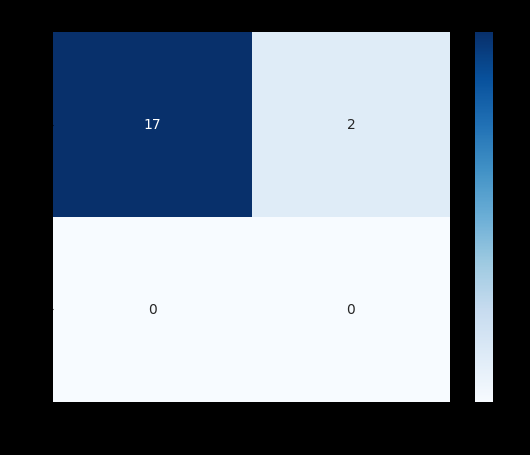

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
#predicted_labels = torch.cat(predicted_labels_list, dim=0).squeeze().cpu()

#true_labels = torch.cat(labels_list, dim=0)

# Confusion Matrix
#true_labels = true_labels.detach().numpy()
#predicted_labels = predicted_labels.detach().numpy()
cm = confusion_matrix(true_labels, predicted_labels_list)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()